# Prepare Data for Training & Validating & Testing

## Dataset
- [**IMDB Large Movie Review Dataset**](http://ai.stanford.edu/~amaas/data/sentiment/)
    - Binary sentiment classification
    - Citation: [Andrew L. Maas et al., 2011](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf)
    - 50,000 movie reviews for training and testing
    - Average review length: 231 vocab
    ---
- [**Yelp reviews-full**](http://xzh.me/docs/charconvnet.pdf)
    - Multiclass sentiment classification (5 stars)
    - Citation: [Xiang Zhang et al., 2015](https://arxiv.org/abs/1509.01626)
    - 650,000 training samples and 50,000 testing samples (Nums of each star are equal)
    - Average review length: 140 vocab
    ---
- [**Yelp reviews-polarity**](http://xzh.me/docs/charconvnet.pdf)
    - Binary sentiment classification
    - Citation: [Xiang Zhang et al., 2015](https://arxiv.org/abs/1509.01626)
    - 560,000 training samples and 38,000 testing samples (Nums of positive or negative samples are equal)
    - Average review length: 140 vocab
    ---
- [**Douban Movie Reviews**](https://drive.google.com/open?id=1DsmQfB1Ff_BUoxOv4kfUMg7Y8M7tHB9F) 
    - My Custom Chinese movie reviews dataset scraped by python extension package requests
    - Binary sentiment classification
    - 750,000 movie reviews from [Douban](https://movie.douban.com/), 650,000 samples for training and 100,000 samples for testing (Num of positive or negative samples is equal)
    - Average review length: 52 character, 28 vocab

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from utils import clean_text, clean_text_zh
%matplotlib inline
%load_ext autoreload
%autoreload 2

## IMDB

In [2]:
df = pd.read_csv('dataset/IMDB/imdb_master.csv', encoding='latin-1')

In [3]:
df.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [4]:
df = df[df['label'] != 'unsup']
df['label'] = df['label'].map({'neg':0, 'pos':1})
df.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,0,0_2.txt
1,1,test,This is an example of why the majority of acti...,0,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",0,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,0,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,0,10003_3.txt


In [5]:
df['Processed_Reviews'] = df['review'].apply(clean_text)

In [6]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0, stratify=df.label)

In [7]:
df_train, df_validate = train_test_split(df_train, test_size=5000, random_state=0, stratify=df_train.label)

In [8]:
print("Train set size: ", len(df_train))
print("Validation set size: ", len(df_validate))
print("Test set size: ", len(df_test))

Train set size:  40000
Validation set size:  5000
Test set size:  5000


Text(0, 0.5, 'Counts')

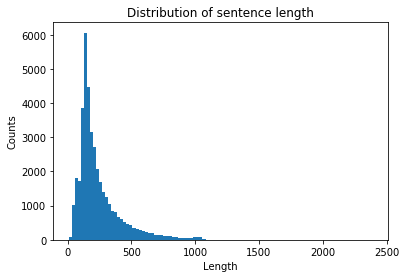

In [9]:
plt.figure()
_ = plt.hist(df_train.Processed_Reviews.apply(lambda x: len(x.split())), bins = 100)
plt.title('Distribution of sentence length')
plt.xlabel('Length')
plt.ylabel('Counts')

### Word sequence to num sequence

In [10]:
word_count = {}
def count(x):
    for word in x.split():
        word_count[word] = word_count.get(word, 0) + 1

In [11]:
_ = df_train.Processed_Reviews.apply(count)

In [12]:
df_word_count = pd.DataFrame(list(word_count.items()), columns=['word', 'count'])
df_word_count.sort_values(by='count', ascending=False, inplace=True)
df_word_count.set_index('word', inplace=True)

In [13]:
df_word_count.drop(['the', 'a', 'and', 'of', 'to', 'br', 'in', 'this', 'that', 's'], inplace=True)

In [14]:
vocab_size = 20000
df_word_count = df_word_count[:vocab_size-3]

In [15]:
word2num_series = df_word_count.reset_index().reset_index().set_index('word')['index'] + 3 # reverse 0, 1, 2 for padding, BOS, EOS

In [16]:
X_train = df_train.Processed_Reviews.apply(lambda x: np.array([word2num_series[word] for word in x.split() if word in word2num_series], dtype=np.int32))

In [17]:
y_train = df_train.label

### Process validation set and test set

In [18]:
X_val = df_validate.Processed_Reviews.apply(lambda x: np.array([word2num_series[word] for word in x.split() if word in word2num_series], dtype=np.int32))
X_test = df_test.Processed_Reviews.apply(lambda x: np.array([word2num_series[word] for word in x.split() if word in word2num_series], dtype=np.int32))
y_val = df_validate.label
y_test = df_test.label

### Save the data into h5 file

In [19]:
X_train.to_hdf('dataset/IMDB/X_train.h5', key='s', model='w')
y_train.to_hdf('dataset/IMDB/y_train.h5', key='s', model='w')

X_val.to_hdf('dataset/IMDB/X_val.h5', key='s', model='w')
y_val.to_hdf('dataset/IMDB/y_val.h5', key='s', model='w')

X_test.to_hdf('dataset/IMDB/X_test.h5', key='s', model='w')
y_test.to_hdf('dataset/IMDB/y_test.h5', key='s', model='w')
word2num_series.to_hdf('dataset/IMDB/word2num_series.h5', key='s', model='w')

# Yelp Reviews Polarity

In [40]:
df = pd.read_csv('dataset/yelp_review_polarity_csv/train.csv', header=None)

In [41]:
df_test = pd.read_csv('dataset/yelp_review_polarity_csv/test.csv', header=None)

In [43]:
df.columns = ['label', 'review']
df['label'] = df['label'].map({1:0, 2:1})
df_test.columns = ['label', 'review']
df_test['label'] = df_test['label'].map({1:0, 2:1})

In [44]:
df.count()

label     560000
review    560000
dtype: int64

In [46]:
df_test.count()

label     38000
review    38000
dtype: int64

In [47]:
df['Processed_Reviews'] = df['review'].apply(lambda x: clean_text(x))
df_test['Processed_Reviews'] = df_test['review'].apply(lambda x: clean_text(x))

In [48]:
df['Processed_Reviews'].apply(lambda x: len(x.split())).mean()

140.4831017857143

In [54]:
df_train, df_validate = train_test_split(df, test_size=40000, random_state=0, stratify=df.label)

In [55]:
print("Train set size: ", len(df_train))
print("Validation set size: ", len(df_validate))
print("Test set size: ", len(df_test))

Train set size:  520000
Validation set size:  40000
Test set size:  38000


Text(0, 0.5, 'Counts')

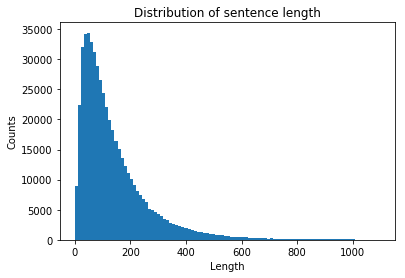

In [56]:
plt.figure()
_ = plt.hist(df_train.Processed_Reviews.apply(lambda x: len(x.split())), bins = 100)
plt.title('Distribution of sentence length')
plt.xlabel('Length')
plt.ylabel('Counts')

In [57]:
word_count = {}
def count(x):
    for word in x.split():
        word_count[word] = word_count.get(word, 0) + 1

In [58]:
_ = df_train.Processed_Reviews.apply(count)

In [59]:
df_word_count = pd.DataFrame(list(word_count.items()), columns=['word', 'count'])
df_word_count.sort_values(by='count', ascending=False, inplace=True)
df_word_count.set_index('word', inplace=True)

In [61]:
df_word_count.drop(['the', 'a', 'and', 'of', 'to', 'br', 'in', 'this', 'that', 's', 'n'], inplace=True)

In [62]:
vocab_size = 40000
df_word_count = df_word_count[:vocab_size-3]

In [63]:
word2num_series = df_word_count.reset_index().reset_index().set_index('word')['index'] + 3 # reverse 0, 1, 2 for padding, BOS, EOS

In [65]:
X_train = df_train.Processed_Reviews.apply(lambda x: np.array([word2num_series[word] for word in x.split() if word in word2num_series], dtype=np.int32))
y_train = df_train.label

In [66]:
X_val = df_validate.Processed_Reviews.apply(lambda x: np.array([word2num_series[word] for word in x.split() if word in word2num_series], dtype=np.int32))
X_test = df_test.Processed_Reviews.apply(lambda x: np.array([word2num_series[word] for word in x.split() if word in word2num_series], dtype=np.int32))
y_val = df_validate.label
y_test = df_test.label

In [68]:
X_train.to_hdf('dataset/yelp_review_polarity_csv/X_train.h5', key='s', model='w')
y_train.to_hdf('dataset/yelp_review_polarity_csv/y_train.h5', key='s', model='w')

X_val.to_hdf('dataset/yelp_review_polarity_csv/X_val.h5', key='s', model='w')
y_val.to_hdf('dataset/yelp_review_polarity_csv/y_val.h5', key='s', model='w')

X_test.to_hdf('dataset/yelp_review_polarity_csv/X_test.h5', key='s', model='w')
y_test.to_hdf('dataset/yelp_review_polarity_csv/y_test.h5', key='s', model='w')
word2num_series.to_hdf('dataset/yelp_review_polarity_csv/word2num_series.h5', key='s', model='w')

## Yelp Reviews Full

In [70]:
df = pd.read_csv('dataset/yelp_review_full_csv/train.csv', header=None)
df_test = pd.read_csv('dataset/yelp_review_full_csv/test.csv', header=None)

In [77]:
df.columns = ['label', 'review']
df_test.columns = ['label', 'review']

In [81]:
df['Processed_Reviews'] = df['review'].apply(lambda x: clean_text(x))
df_test['Processed_Reviews'] = df_test['review'].apply(lambda x: clean_text(x))

In [82]:
df['Processed_Reviews'].apply(lambda x: len(x.split())).mean()

141.65482307692307

In [84]:
df_train, df_validate = train_test_split(df, test_size=50000, random_state=0, stratify=df.label)

In [87]:
print("Train set size: ", len(df_train))
print("Validation set size: ", len(df_validate))
print("Test set size: ", len(df_test))

Train set size:  600000
Validation set size:  50000
Test set size:  50000


Text(0, 0.5, 'Counts')

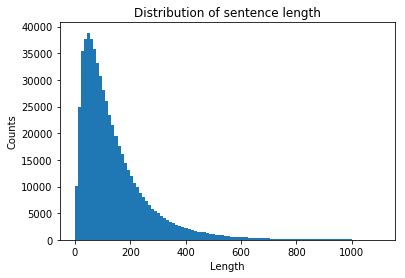

In [88]:
plt.figure()
_ = plt.hist(df_train.Processed_Reviews.apply(lambda x: len(x.split())), bins = 100)
plt.title('Distribution of sentence length')
plt.xlabel('Length')
plt.ylabel('Counts')

In [89]:
word_count = {}
def count(x):
    for word in x.split():
        word_count[word] = word_count.get(word, 0) + 1

In [90]:
_ = df_train.Processed_Reviews.apply(count)

In [91]:
df_word_count = pd.DataFrame(list(word_count.items()), columns=['word', 'count'])
df_word_count.sort_values(by='count', ascending=False, inplace=True)
df_word_count.set_index('word', inplace=True)

In [93]:
df_word_count.drop(['the', 'a', 'and', 'of', 'to', 'br', 'in', 'this', 'that', 's', 'n'], inplace=True)

In [100]:
vocab_size = 40000
df_word_count = df_word_count[:vocab_size-3]

In [101]:
word2num_series = df_word_count.reset_index().reset_index().set_index('word')['index'] + 3 # reverse 0, 1, 2 for padding, BOS, EOS

In [102]:
X_train = df_train.Processed_Reviews.apply(lambda x: np.array([word2num_series[word] for word in x.split() if word in word2num_series], dtype=np.int32))
y_train = df_train.label

In [103]:
X_val = df_validate.Processed_Reviews.apply(lambda x: np.array([word2num_series[word] for word in x.split() if word in word2num_series], dtype=np.int32))
X_test = df_test.Processed_Reviews.apply(lambda x: np.array([word2num_series[word] for word in x.split() if word in word2num_series], dtype=np.int32))
y_val = df_validate.label
y_test = df_test.label

In [104]:
X_train.to_hdf('dataset/yelp_review_full_csv/X_train.h5', key='s', model='w')
y_train.to_hdf('dataset/yelp_review_full_csv/y_train.h5', key='s', model='w')

X_val.to_hdf('dataset/yelp_review_full_csv/X_val.h5', key='s', model='w')
y_val.to_hdf('dataset/yelp_review_full_csv/y_val.h5', key='s', model='w')

X_test.to_hdf('dataset/yelp_review_full_csv/X_test.h5', key='s', model='w')
y_test.to_hdf('dataset/yelp_review_full_csv/y_test.h5', key='s', model='w')
word2num_series.to_hdf('dataset/yelp_review_full_csv/word2num_series.h5', key='s', model='w')

## Douban Dataset

In [5]:
df = pd.read_csv('dataset/Douban/train.csv')
df_test = pd.read_csv('dataset/Douban/test.csv')

In [6]:
len(df)

600000

In [7]:
len(df_test)

100000

In [9]:
df['Processed_Reviews'] = df['content'].apply(clean_text_zh)
df_test['Processed_Reviews'] = df_test['content'].apply(clean_text_zh)

In [10]:
import jieba

In [11]:
df['Processed_Reviews'].apply(lambda x: len([word for word in jieba.cut(x) if word.strip()])).mean()

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\Jackdong\AppData\Local\Temp\jieba.cache
Loading model cost 1.128 seconds.
Prefix dict has been built succesfully.


27.412871666666668

In [12]:
df['content'].apply(lambda x: len(x)).mean()

51.59234333333333

In [13]:
len(df)

600000

In [14]:
df_train, df_validate = train_test_split(df, test_size=50000, random_state=0, stratify=df.label)

In [15]:
print("Train set size: ", len(df_train))
print("Validation set size: ", len(df_validate))
print("Test set size: ", len(df_test))

Train set size:  550000
Validation set size:  50000
Test set size:  100000


Text(0, 0.5, 'Counts')

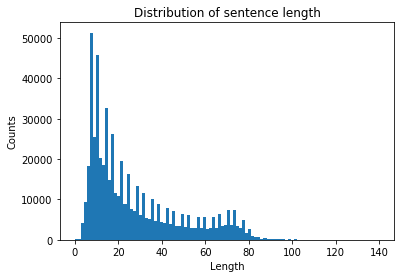

In [16]:
plt.figure()
_ = plt.hist(df_train.Processed_Reviews.apply(lambda x: len([word for word in jieba.cut(x) if word.strip()])), bins = 100)
plt.title('Distribution of sentence length')
plt.xlabel('Length')
plt.ylabel('Counts')

In [17]:
word_count = {}
def count(x):
    for word in jieba.cut(x):
        word_count[word] = word_count.get(word, 0) + 1

In [18]:
_ = df_train.Processed_Reviews.apply(count)

In [19]:
df_word_count = pd.DataFrame(list(word_count.items()), columns=['word', 'count'])
df_word_count.sort_values(by='count', ascending=False, inplace=True)
df_word_count.set_index('word', inplace=True)

In [20]:
df_word_count.drop([' ', '的', '了', '是', '都', '在', '就'], inplace=True)

In [21]:
vocab_size = 40000
df_word_count = df_word_count[:vocab_size-3]

In [22]:
word2num_series = df_word_count.reset_index().reset_index().set_index('word')['index'] + 3 # reverse 0, 1, 2 for padding, BOS, EOS

In [23]:
X_train = df_train.Processed_Reviews.apply(lambda x: np.array([word2num_series[word] for word in jieba.cut(x) if word in word2num_series], dtype=np.int32))
y_train = df_train.label

In [24]:
X_val = df_validate.Processed_Reviews.apply(lambda x: np.array([word2num_series[word] for word in jieba.cut(x) if word in word2num_series], dtype=np.int32))
X_test = df_test.Processed_Reviews.apply(lambda x: np.array([word2num_series[word] for word in jieba.cut(x) if word in word2num_series], dtype=np.int32))
y_val = df_validate.label
y_test = df_test.label

In [25]:
X_train.to_hdf('dataset/Douban/X_train.h5', key='s', model='w')
y_train.to_hdf('dataset/Douban/y_train.h5', key='s', model='w')

X_val.to_hdf('dataset/Douban/X_val.h5', key='s', model='w')
y_val.to_hdf('dataset/Douban/y_val.h5', key='s', model='w')

X_test.to_hdf('dataset/Douban/X_test.h5', key='s', model='w')
y_test.to_hdf('dataset/Douban/y_test.h5', key='s', model='w')
word2num_series.to_hdf('dataset/Douban/word2num_series.h5', key='s', model='w')

## Amazon Review Polarity


In [2]:
df = pd.read_csv('dataset/amazon_review_polarity_csv/train.csv', header=None)
df_test = pd.read_csv('dataset/amazon_review_polarity_csv/test.csv', header=None)

In [3]:
len(df)

3600000

In [10]:
df.columns = ['label', 'title', 'review']
df_test.columns = ['label', 'title', 'review']

In [14]:
df['label'] = df['label'].map({1:0, 2:1})
df_test['label'] = df_test['label'].map({1:0, 2:1})

In [17]:
df.head()

,label,title,review
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,1,Amazing!,This soundtrack is my favorite music of all ti...
3,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [13]:
df['review'].apply(lambda x: len(x.split())).mean()

74.16884944444445

In [19]:
df['Processed_Reviews'] = df['review'].apply(lambda x: clean_text(x))
df_test['Processed_Reviews'] = df_test['review'].apply(lambda x: clean_text(x))

In [20]:
df_train, df_validate = train_test_split(df, test_size=400000, random_state=0, stratify=df.label)

In [21]:
print("Train set size: ", len(df_train))
print("Validation set size: ", len(df_validate))
print("Test set size: ", len(df_test))

Train set size:  3200000
Validation set size:  400000
Test set size:  400000


In [22]:
word_count = {}
def count(x):
    for word in x.split():
        word_count[word] = word_count.get(word, 0) + 1

In [23]:
_ = df_train.Processed_Reviews.apply(count)

In [24]:
df_word_count = pd.DataFrame(list(word_count.items()), columns=['word', 'count'])
df_word_count.sort_values(by='count', ascending=False, inplace=True)
df_word_count.set_index('word', inplace=True)

In [26]:
df_word_count.drop(['the', 'a', 'and', 'of', 'to', 'in', 'this', 'that', 's', 'n', 'for'], inplace=True)

In [33]:
vocab_size = 40000
df_word_count = df_word_count[:vocab_size-3]

In [34]:
word2num_series = df_word_count.reset_index().reset_index().set_index('word')['index'] + 3 # reverse 0, 1, 2 for padding, BOS, EOS

In [35]:
X_train = df_train.Processed_Reviews.apply(lambda x: np.array([word2num_series[word] for word in x.split() if word in word2num_series], dtype=np.int32))
y_train = df_train.label

In [36]:
X_val = df_validate.Processed_Reviews.apply(lambda x: np.array([word2num_series[word] for word in x.split() if word in word2num_series], dtype=np.int32))
X_test = df_test.Processed_Reviews.apply(lambda x: np.array([word2num_series[word] for word in x.split() if word in word2num_series], dtype=np.int32))
y_val = df_validate.label
y_test = df_test.label

In [37]:
X_train.to_hdf('dataset/amazon_review_polarity_csv/X_train.h5', key='s', model='w')
y_train.to_hdf('dataset/amazon_review_polarity_csv/y_train.h5', key='s', model='w')

X_val.to_hdf('dataset/amazon_review_polarity_csv/X_val.h5', key='s', model='w')
y_val.to_hdf('dataset/amazon_review_polarity_csv/y_val.h5', key='s', model='w')

X_test.to_hdf('dataset/amazon_review_polarity_csv/X_test.h5', key='s', model='w')
y_test.to_hdf('dataset/amazon_review_polarity_csv/y_test.h5', key='s', model='w')
word2num_series.to_hdf('dataset/amazon_review_polarity_csv/word2num_series.h5', key='s', model='w')